In [1]:
# =====================
# 1. Imports and Setup
# =====================
import os
import numpy as np
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, Callback

In [2]:
# =====================
# 2. Transformations
# =====================
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [3]:
# =====================
# 3. Data Module
# =====================
class DataModule(pl.LightningDataModule):
    def __init__(self, root_dir="DataSet/Skin Disease/Skin Cancer Dataset", transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        full_dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_total = len(full_dataset)
        n_train = int(0.7 * n_total)
        n_val = int(0.15 * n_total)
        n_test = n_total - n_train - n_val

        self.train_set, self.val_set, self.test_set = random_split(full_dataset, [n_train, n_val, n_test])

        targets = [sample[1] for sample in self.train_set]
        class_counts = Counter(targets)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[cls] for cls in targets]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, sampler=sampler)
        self.val_loader = DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False)

        self.class_names = full_dataset.classes

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader



In [4]:
# =====================
# 4. Hybrid ResNet18 Model
# =====================
class HybridResNet18(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        base = models.resnet18(pretrained=True)
        for param in list(base.parameters())[:-15]:
            param.requires_grad = False

        base.fc = nn.Identity()

        self.backbone = base
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        self.train_losses, self.train_accs = [], []
        self.val_losses, self.val_accs = [], []

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

    def configure_optimizers(self):
        return torch.optim.AdamW([
            {'params': self.backbone.parameters(), 'lr': 3e-5},
            {'params': self.classifier.parameters(), 'lr': 8e-4}
        ])

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", acc, prog_bar=False)
        return {"loss": loss, "train_acc": acc}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return {"test_loss": loss, "test_acc": acc}



In [5]:
# =====================
# 5. Custom Logger
# =====================
class CustomLogger(Callback):
    def on_validation_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        if pl_module.train_losses and pl_module.val_losses:
            train_loss = pl_module.train_losses[-1]
            train_acc = pl_module.train_accs[-1]
            val_loss = pl_module.val_losses[-1]
            val_acc = pl_module.val_accs[-1]
            print(f"[Epoch: {epoch+1}] Train: [loss: {train_loss:.3f} acc: {train_acc:.3f}] Val: [loss: {val_loss:.3f} acc:{val_acc:.3f}]")



In [6]:
# =====================
# 6. Train Block
# =====================
pl.seed_everything(42)
datamodule = DataModule()
datamodule.setup()

model = HybridResNet18(num_classes=len(datamodule.class_names))
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5), CustomLogger()],
    accelerator="auto",
    enable_progress_bar=False
)

Seed set to 42
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | backbone   | ResNet     | 11.2 M | train
1 | classifier | Sequential | 66.8 K | train
--------------------------------------------------
7.3 M     Trainable params
4.0 M     Non-trainable params
11.2 M    Total params
44.973    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Con

[Epoch: 1] Train: [loss: 1.217 acc: 0.621] Val: [loss: 1.676 acc:0.375]
[Epoch: 2] Train: [loss: 0.919 acc: 0.690] Val: [loss: 1.661 acc:0.250]
[Epoch: 3] Train: [loss: 0.828 acc: 0.690] Val: [loss: 1.641 acc:0.375]
[Epoch: 4] Train: [loss: 0.745 acc: 0.759] Val: [loss: 1.526 acc:0.250]
[Epoch: 5] Train: [loss: 0.761 acc: 0.690] Val: [loss: 1.291 acc:0.625]
[Epoch: 6] Train: [loss: 0.761 acc: 0.655] Val: [loss: 1.572 acc:0.375]
[Epoch: 7] Train: [loss: 0.751 acc: 0.690] Val: [loss: 1.390 acc:0.375]
[Epoch: 8] Train: [loss: 0.301 acc: 0.862] Val: [loss: 2.131 acc:0.250]
[Epoch: 9] Train: [loss: 0.871 acc: 0.621] Val: [loss: 2.130 acc:0.250]
[Epoch: 10] Train: [loss: 0.612 acc: 0.793] Val: [loss: 2.305 acc:0.375]
[Epoch: 11] Train: [loss: 0.262 acc: 0.931] Val: [loss: 2.285 acc:0.250]
[Epoch: 12] Train: [loss: 0.312 acc: 0.828] Val: [loss: 2.377 acc:0.375]
[Epoch: 13] Train: [loss: 0.398 acc: 0.897] Val: [loss: 1.440 acc:0.375]


In [8]:
# =====================
# 7. Test Block
# =====================
trainer.test(model, datamodule)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8592233061790466     │
│         test_loss         │    0.4593672752380371     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4593672752380371, 'test_acc': 0.8592233061790466}]

In [10]:
# =====================
# 8. Evaluate Block
# =====================
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in datamodule.test_dataloader():
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=datamodule.class_names, digits=4))

                            precision    recall  f1-score   support

        Acitinic Keratosis     0.7500    0.8077    0.7778        78
      Basal Cell Carcinoma     0.6901    0.7313    0.7101        67
            Dermatofibroma     0.7361    0.9298    0.8217        57
                  Melanoma     0.8736    0.8736    0.8736        87
                     Nevus     0.9412    0.9302    0.9357        86
Pigmented Benign Keratosis     0.9324    0.9583    0.9452        72
      Seborrheic Keratosis     0.9455    0.6667    0.7820        78
   Squamous Cell Carcinoma     0.8333    0.7692    0.8000        52
           Vascular Lesion     0.9048    0.9268    0.9157        41

                  accuracy                         0.8414       618
                 macro avg     0.8452    0.8437    0.8402       618
              weighted avg     0.8494    0.8414    0.8410       618



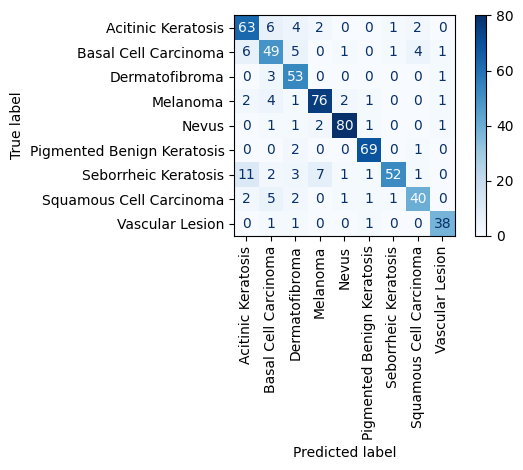

In [11]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=datamodule.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

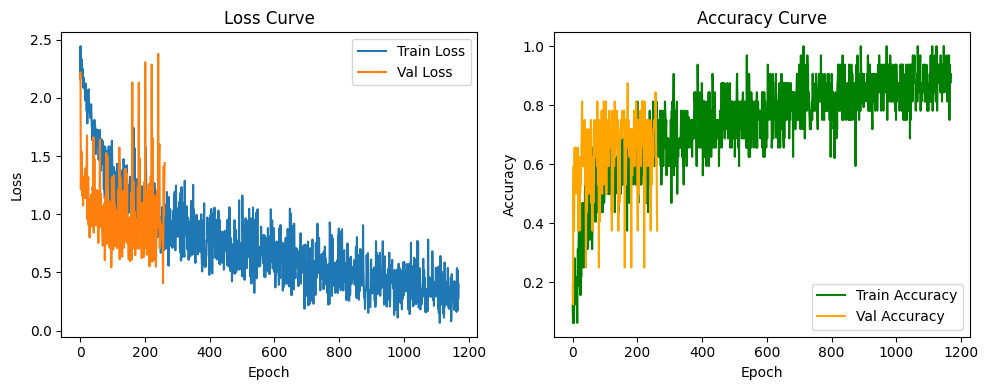

In [12]:
# =====================
# 10. Plot Training Curves
# =====================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.train_accs, label="Train Accuracy", color="green")
plt.plot(model.val_accs, label="Val Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()

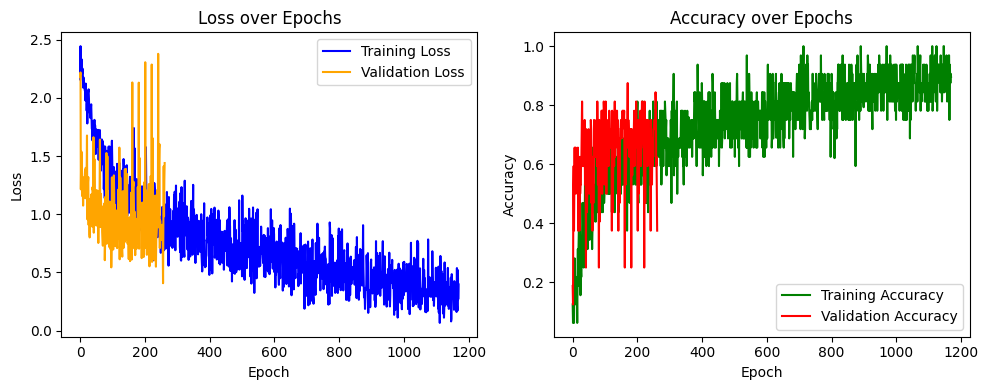

In [13]:
# =====================
# 10. رسم منحنيات الأداء
# =====================

import matplotlib.pyplot as plt

# تأكد من وجود القيم
if model.train_losses and model.val_losses and model.train_accs and model.val_accs:
    plt.figure(figsize=(10, 4))

    # منحنى الخسارة
    plt.subplot(1, 2, 1)
    plt.plot(model.train_losses, label='Training Loss', color='blue')
    plt.plot(model.val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # منحنى الدقة
    plt.subplot(1, 2, 2)
    plt.plot(model.train_accs, label='Training Accuracy', color='green')
    plt.plot(model.val_accs, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("❌ لا توجد بيانات كافية لرسم المنحنيات. تأكد من تشغيل التدريب أولًا.")


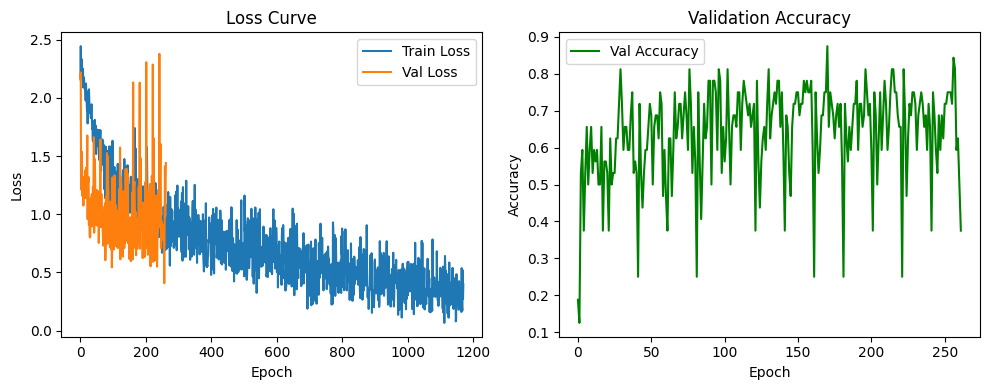

In [14]:
# =====================
# 8. Plot Loss and Accuracy
# =====================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(model.val_accs, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

In [15]:
# =====================
# 9. Save the Model
# =====================
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

example_input = torch.rand(1, 3, 224, 224).to(device)

# TorchScript
traced_model = torch.jit.trace(model, example_input)
traced_model.save("hybrid_resnet18_skin__model_traced_jit.pt")
print("TorchScript model saved as resnet18__skin_model_traced_jit.pt")

TorchScript model saved as resnet18__skin_model_traced_jit.pt


In [18]:
torch.save(model.state_dict(), "hybrid_resnet18_skin_model_state_dict.pt")

In [17]:
# ONNX Export
onnx_path = "hybrid_resnet18_skin_model_ONNX.onnx"
torch.onnx.export(model, example_input, onnx_path,
                  input_names=["input"],
                  output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)  # ← أضف هذا السطر لإنهاء الدالة بشكل صحيح
print(f"Model saved to {onnx_path}")


Model saved to hybrid_resnet18_skin_model_ONNX.onnx
